# Clustering FIFA players

**FIFA Dataset:** The data set was scraped from [this website](https://sofifa.com/). For non-football enthusiasts, you can check out Wiki website for more clarification about football player's positions. [Find type and meaning of positions here](https://en.wikipedia.org/wiki/Association_football_positions).
        
In this notebook I compare the actual preferred position of the players with the most suitable one based on the characterisics of ech player.
        
**Topics Trained:** Unsupervised Learning, Feature correlations, Clustering and Outliers detection methods, Visualizations, Pipelines and Model Selection.

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load dependencies

In [22]:
# auto reload packages and modules when they are modified
%load_ext autoreload
%autoreload 2
# %load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# GENERAL

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# VISUALIZATION

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# PRE-PROCESSING

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_samples, silhouette_score

# PIPELINE AND MODELS

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

### Necessary Functions for this Notebook

In [24]:
# DESCRIPTION --> # it plots the distributions of your data
def plot_distrib(df, ncols, nrows, figsize):
    vars_ = df.columns
    c = 0
    plt.figure(figsize=figsize)
    for v in vars_:
        ax = plt.subplot(nrows, ncols, c + 1)
        _, nbins, _ = plt.hist(df[v], 20, color="g", alpha=0.6, label=v)
        plt.xlabel(v)
        plt.legend(loc="best")
        c = c + 1
    plt.show()
    
# How to call this function? --> plot_distrib (target_df, number_of_cols, number_of_rows, figsize)

### Visualizations set-up

In [25]:
plt.style.use("default")
plt.rcParams.update({"font.size": 18, "figure.figsize": (18, 10)})

## Data Loading

In [26]:
from google.colab import files
files.upload()

{}

In [27]:
files.upload()

{}

In [28]:
# Data Loading:

url_1 = 'PlayerAttributeData.csv'
attr = pd.read_csv(url_1, dtype=str, index_col=0)  

# Data Loading:

url_2 = "PlayerPlayingPositionData.csv"
data_pos = pd.read_csv(url_2, dtype=str, index_col=0) 

## Data Exploration

In [29]:
# Data frame size:

attr.shape

(17981, 35)

In [30]:
# Data frame initial aspect:

attr.head()

,Acceleration,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,GK diving,GK handling,GK kicking,GK positioning,GK reflexes,Heading accuracy,ID,Interceptions,Jumping,Long passing,Long shots,Marking,Penalties,Positioning,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys
0,89,63,89,63,93,95,85,81,91,94,76,7,11,15,14,11,88,20801,29,95,77,92,22,85,95,96,83,94,23,91,92,31,80,85,88
1,92,48,90,95,95,96,77,89,97,95,90,6,11,15,14,8,71,158023,22,68,87,88,13,74,93,95,88,85,26,87,73,28,59,90,85
2,94,56,96,82,95,92,75,81,96,89,84,9,9,15,15,11,62,190871,36,61,75,77,21,81,90,88,81,80,33,90,78,24,53,80,83
3,88,78,86,60,91,83,77,86,86,94,84,27,25,31,33,37,77,176580,41,69,64,86,30,85,92,93,83,87,38,77,89,45,80,84,88
4,58,29,52,35,48,70,15,14,30,13,11,91,90,95,91,89,25,167495,30,78,59,16,10,47,12,85,55,25,11,61,44,10,83,70,11


<div style="background:#EEEDF5;border:0.1cm solid #EF475B">
    <div style="margin: 0.2cm 0.2cm 0.2cm 0.2cm">
        <b style="color:#EF475B">Warning:</b> 
        We have to rename some columns in order to remove remove spaces contained within their names and also we need to convert letters to lower cases.
    </div>
</div>

In [31]:
# Replacing blank spaces by another character 

attr.columns = attr.columns.str.lower().str.replace(" ", "_")
attr.columns

Index(['acceleration', 'aggression', 'agility', 'balance', 'ball_control',
       'composure', 'crossing', 'curve', 'dribbling', 'finishing',
       'free_kick_accuracy', 'gk_diving', 'gk_handling', 'gk_kicking',
       'gk_positioning', 'gk_reflexes', 'heading_accuracy', 'id',
       'interceptions', 'jumping', 'long_passing', 'long_shots', 'marking',
       'penalties', 'positioning', 'reactions', 'short_passing', 'shot_power',
       'sliding_tackle', 'sprint_speed', 'stamina', 'standing_tackle',
       'strength', 'vision', 'volleys'],
      dtype='object')

In [32]:
# Checking our colum values data types (str, int, float, bool):

print('\nDo we have **strings** inside of our df?:\t', (attr.dtypes == "object").any(), '\n')
print('\nDo we have **integers** inside of our df?:\t', (attr.dtypes == "int").any(), '\n')
print('\nDo we have **floats** inside of our df?:\t', (attr.dtypes == "float64").any(), '\n')
print('\nDo we have **boolean** inside of our df?:\t', (attr.dtypes == "bool").any(), '\n')


Do we have **strings** inside of our df?:	 True 


Do we have **integers** inside of our df?:	 False 


Do we have **floats** inside of our df?:	 False 


Do we have **boolean** inside of our df?:	 False 



In [33]:
attr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17981 entries, 0 to 17980
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   acceleration        17981 non-null  object
 1   aggression          17981 non-null  object
 2   agility             17981 non-null  object
 3   balance             17981 non-null  object
 4   ball_control        17981 non-null  object
 5   composure           17981 non-null  object
 6   crossing            17981 non-null  object
 7   curve               17981 non-null  object
 8   dribbling           17981 non-null  object
 9   finishing           17981 non-null  object
 10  free_kick_accuracy  17981 non-null  object
 11  gk_diving           17981 non-null  object
 12  gk_handling         17981 non-null  object
 13  gk_kicking          17981 non-null  object
 14  gk_positioning      17981 non-null  object
 15  gk_reflexes         17981 non-null  object
 16  heading_accuracy    17

In [34]:
# Checking if any id is duplicated along the df:

check_duplicated_ids = (attr["id"].value_counts() > 1).any()
size_of_duplicated_ids = (attr["id"].value_counts() > 1).sum()
print("Do we have duplicated id's within our df?: ", check_duplicated_ids)
print('\nHow many then?:\t', size_of_duplicated_ids if check_duplicated_ids==True else "None")

Do we have duplicated id's within our df?:  True

How many then?:	 52


In [35]:
print('\nInitial Shape before removing duplicates:\t', attr.shape)
attr = attr.drop_duplicates()
print('\nFinal Shape before removing duplicates:\t', attr.shape, '\n')
attr.info()


Initial Shape before removing duplicates:	 (17981, 35)

Final Shape before removing duplicates:	 (17929, 35) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17929 entries, 0 to 17980
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   acceleration        17929 non-null  object
 1   aggression          17929 non-null  object
 2   agility             17929 non-null  object
 3   balance             17929 non-null  object
 4   ball_control        17929 non-null  object
 5   composure           17929 non-null  object
 6   crossing            17929 non-null  object
 7   curve               17929 non-null  object
 8   dribbling           17929 non-null  object
 9   finishing           17929 non-null  object
 10  free_kick_accuracy  17929 non-null  object
 11  gk_diving           17929 non-null  object
 12  gk_handling         17929 non-null  object
 13  gk_kicking          17929 non-null  object
 14  gk_pos

<div style="background:#EEEDF5;border:0.1cm solid #EF475B">
    <div style="margin: 0.2cm 0.2cm 0.2cm 0.2cm">
        <b style="color:#EF475B">Warning:</b> 
        If we look into the column <b>acceleration</b> we will see that there are some values that contain special characters within them. We must handle them properly
    </div>
</div>

<div style="background:#EEEDF5;"><div style="margin-left: .2cm">
    <b>Comments:</b>
</div></div>

<div style="margin-left: 0.4cm">
    <li>Let's check first the amount of unique values in chosen feature named as: <b>acceleration</b></li>
</div>

In [36]:
print(attr["acceleration"].unique())

['89' '92' '94' '88' '58' '79' '57' '93' '60' '78' '75' '76' '46' '90'
 '68' '49' '43' '87' '77' '95' '62' '72' '65' '70' '63' '82' '69' '67'
 '54' '55' '74' '86' '84' '48' '80' '71' '85' '40' '51' '38' '53' '73'
 '45' '61' '64' '44' '42' '81' '91' '59' '52' '66' '39' '34' '50' '83'
 '47' '96' '31' '30' '70+9' '56' '26' '80+1' '35' '36' '32' '49-1' '41'
 '67+2' '37' '28' '33' '20' '79-2' '65-2' '29' '91-2' '74-3' '75+1' '41-6'
 '74+1' '70+3' '17' '75+5' '74+2' '71+2' '68+1' '71+4' '89-2' '25' '27'
 '24' '58-10' '78+1' '86+1' '66-1' '22' '66+1' '15' '74+4' '71-3' '80+2'
 '21' '23' '64-2' '18' '57-4' '78+3' '19' '73+9' '82-3' '68+3' '68+2'
 '55-8' '55-1' '43-2' '77+3' '82+10' '16' '49-10' '72+1' '61+1' '79+8'
 '70-2' '13' '14' '60-2' '86+7' '81+4' '69+3' '65-10' '64-3' '73+4' '75-6'
 '64+5' '33+10' '92+2' '12' '76-1' '62+2' '65+7' '58+8' '44-2' '77+1'
 '82+3' '68-1' '61+3' '73+3' '59+1' '64+12' '85-1' '78+14' '11' '59-1'
 '75+4' '73+10' '71+6' '77+13' '62+1' '64-5']


In [37]:
# Counting how many data points we are gonna change:

    # all special characters --> '!@#$%^&*()[]{};:,./<>?\|`~-=_+'

sum_findings = attr['acceleration'].str.contains('\+').sum()
subtract_findings = attr['acceleration'].str.contains('\-').sum() 
print('\nTotal amount of cells with the special character "+": ', sum_findings) # printing out the sum
print('\nTotal amount of cells with the special character "-": ', subtract_findings) # printing out the sum


Total amount of cells with the special character "+":  55

Total amount of cells with the special character "-":  29


## Data Pre-processing

In [38]:
attr = attr.applymap(eval)
print('This is how our Acceleration unique values within the column will look like after running the applymap method:\n', 
      attr["acceleration"].unique())

This is how our Acceleration unique values within the column will look like after running the applymap method:
 [89 92 94 88 58 79 57 93 60 78 75 76 46 90 68 49 43 87 77 95 62 72 65 70
 63 82 69 67 54 55 74 86 84 48 80 71 85 40 51 38 53 73 45 61 64 44 42 81
 91 59 52 66 39 34 50 83 47 96 31 30 56 26 35 36 32 41 37 28 33 20 29 17
 25 27 24 22 15 21 23 18 19 16 13 14 12 11]


In [39]:
# Checking how this applymap() method has affected to our df:

attr.dtypes

acceleration          int64
aggression            int64
agility               int64
balance               int64
ball_control          int64
composure             int64
crossing              int64
curve                 int64
dribbling             int64
finishing             int64
free_kick_accuracy    int64
gk_diving             int64
gk_handling           int64
gk_kicking            int64
gk_positioning        int64
gk_reflexes           int64
heading_accuracy      int64
id                    int64
interceptions         int64
jumping               int64
long_passing          int64
long_shots            int64
marking               int64
penalties             int64
positioning           int64
reactions             int64
short_passing         int64
shot_power            int64
sliding_tackle        int64
sprint_speed          int64
stamina               int64
standing_tackle       int64
strength              int64
vision                int64
volleys               int64
dtype: object

## Visualization of the data

### Correlation Heatmap

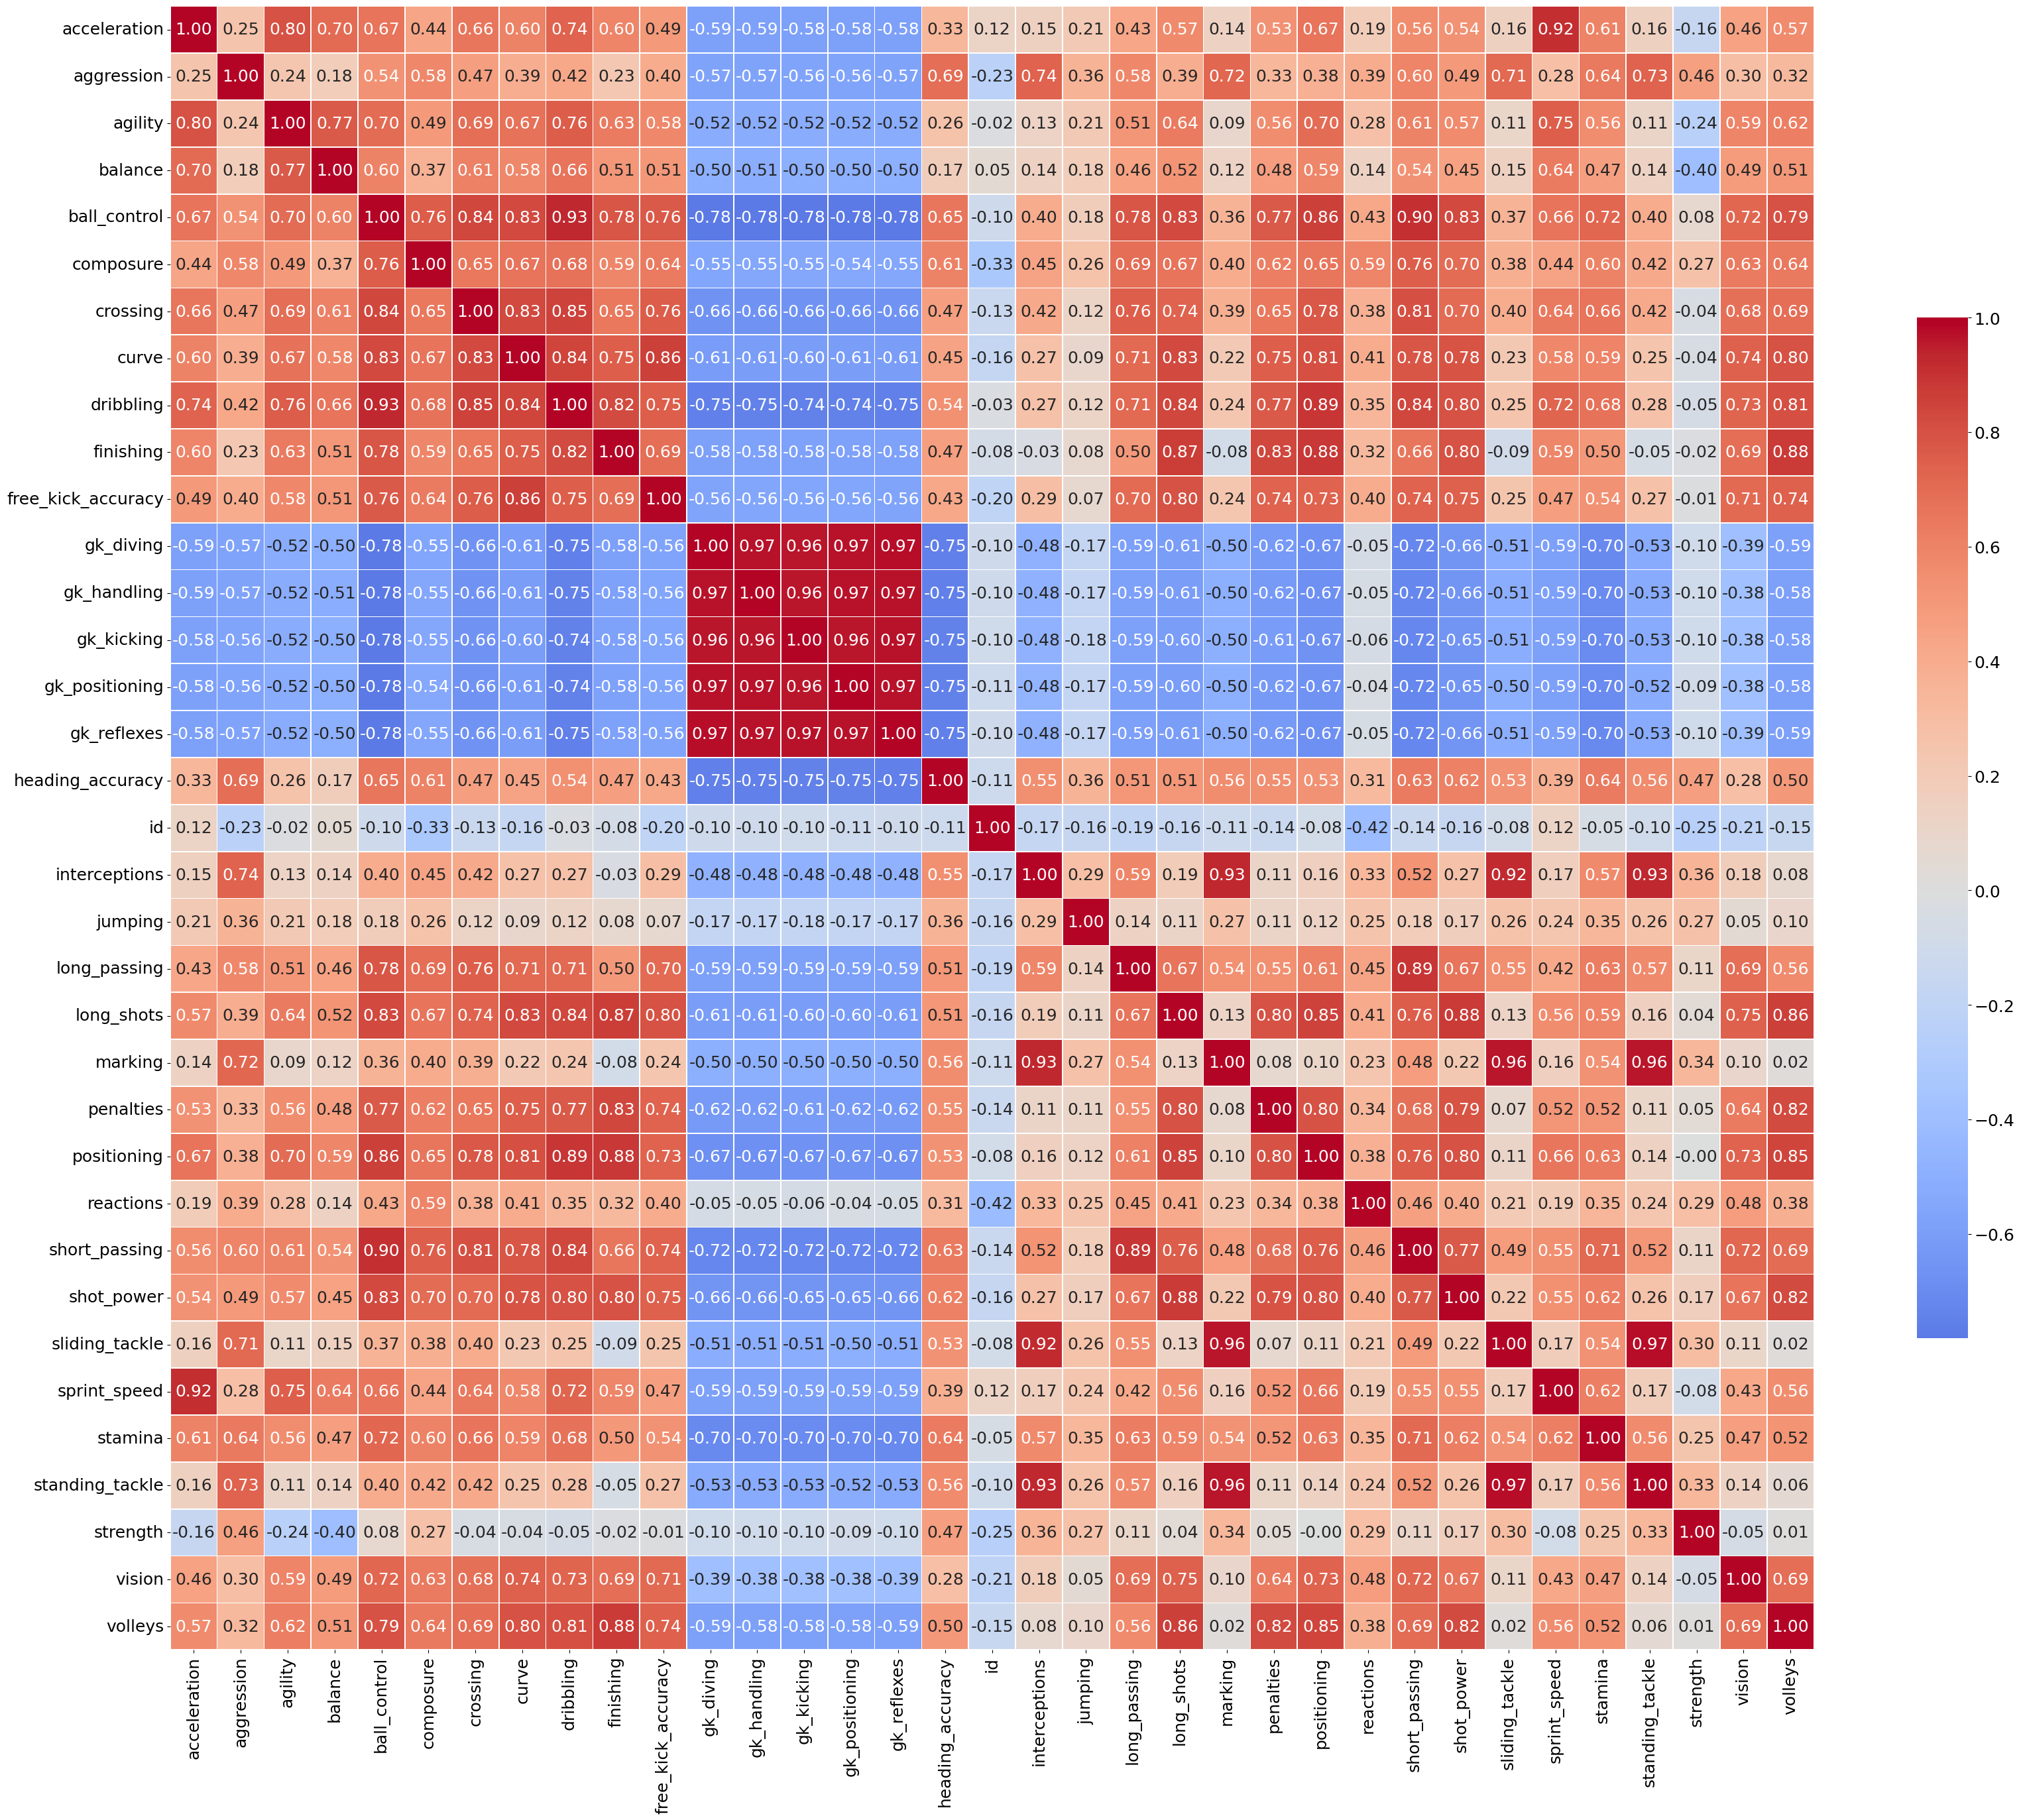

In [40]:
corr = attr.corr() # computing correlation values
fig, ax = plt.subplots(figsize=(40, 40)) # setting up the empty plot to use next

# Assembly of the heatmap:
h = sns.heatmap(
    corr,
    cmap="coolwarm",
    vmax=1,
    fmt=".2f",
    annot=True,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

<div style="background:#EEEDF5;"><div style="margin-left: .2cm">
    <b>Comments:</b>
</div></div>

<div style="margin-left: 0.4cm">
    <li>We can drop the column named as <b>id</b> as it's an player identifier and does not add value in our clustering analysis</li>
</div>

In [41]:
# Dropping out the useless colum we identified:

data = attr.drop("id", axis=1)

### Histograms

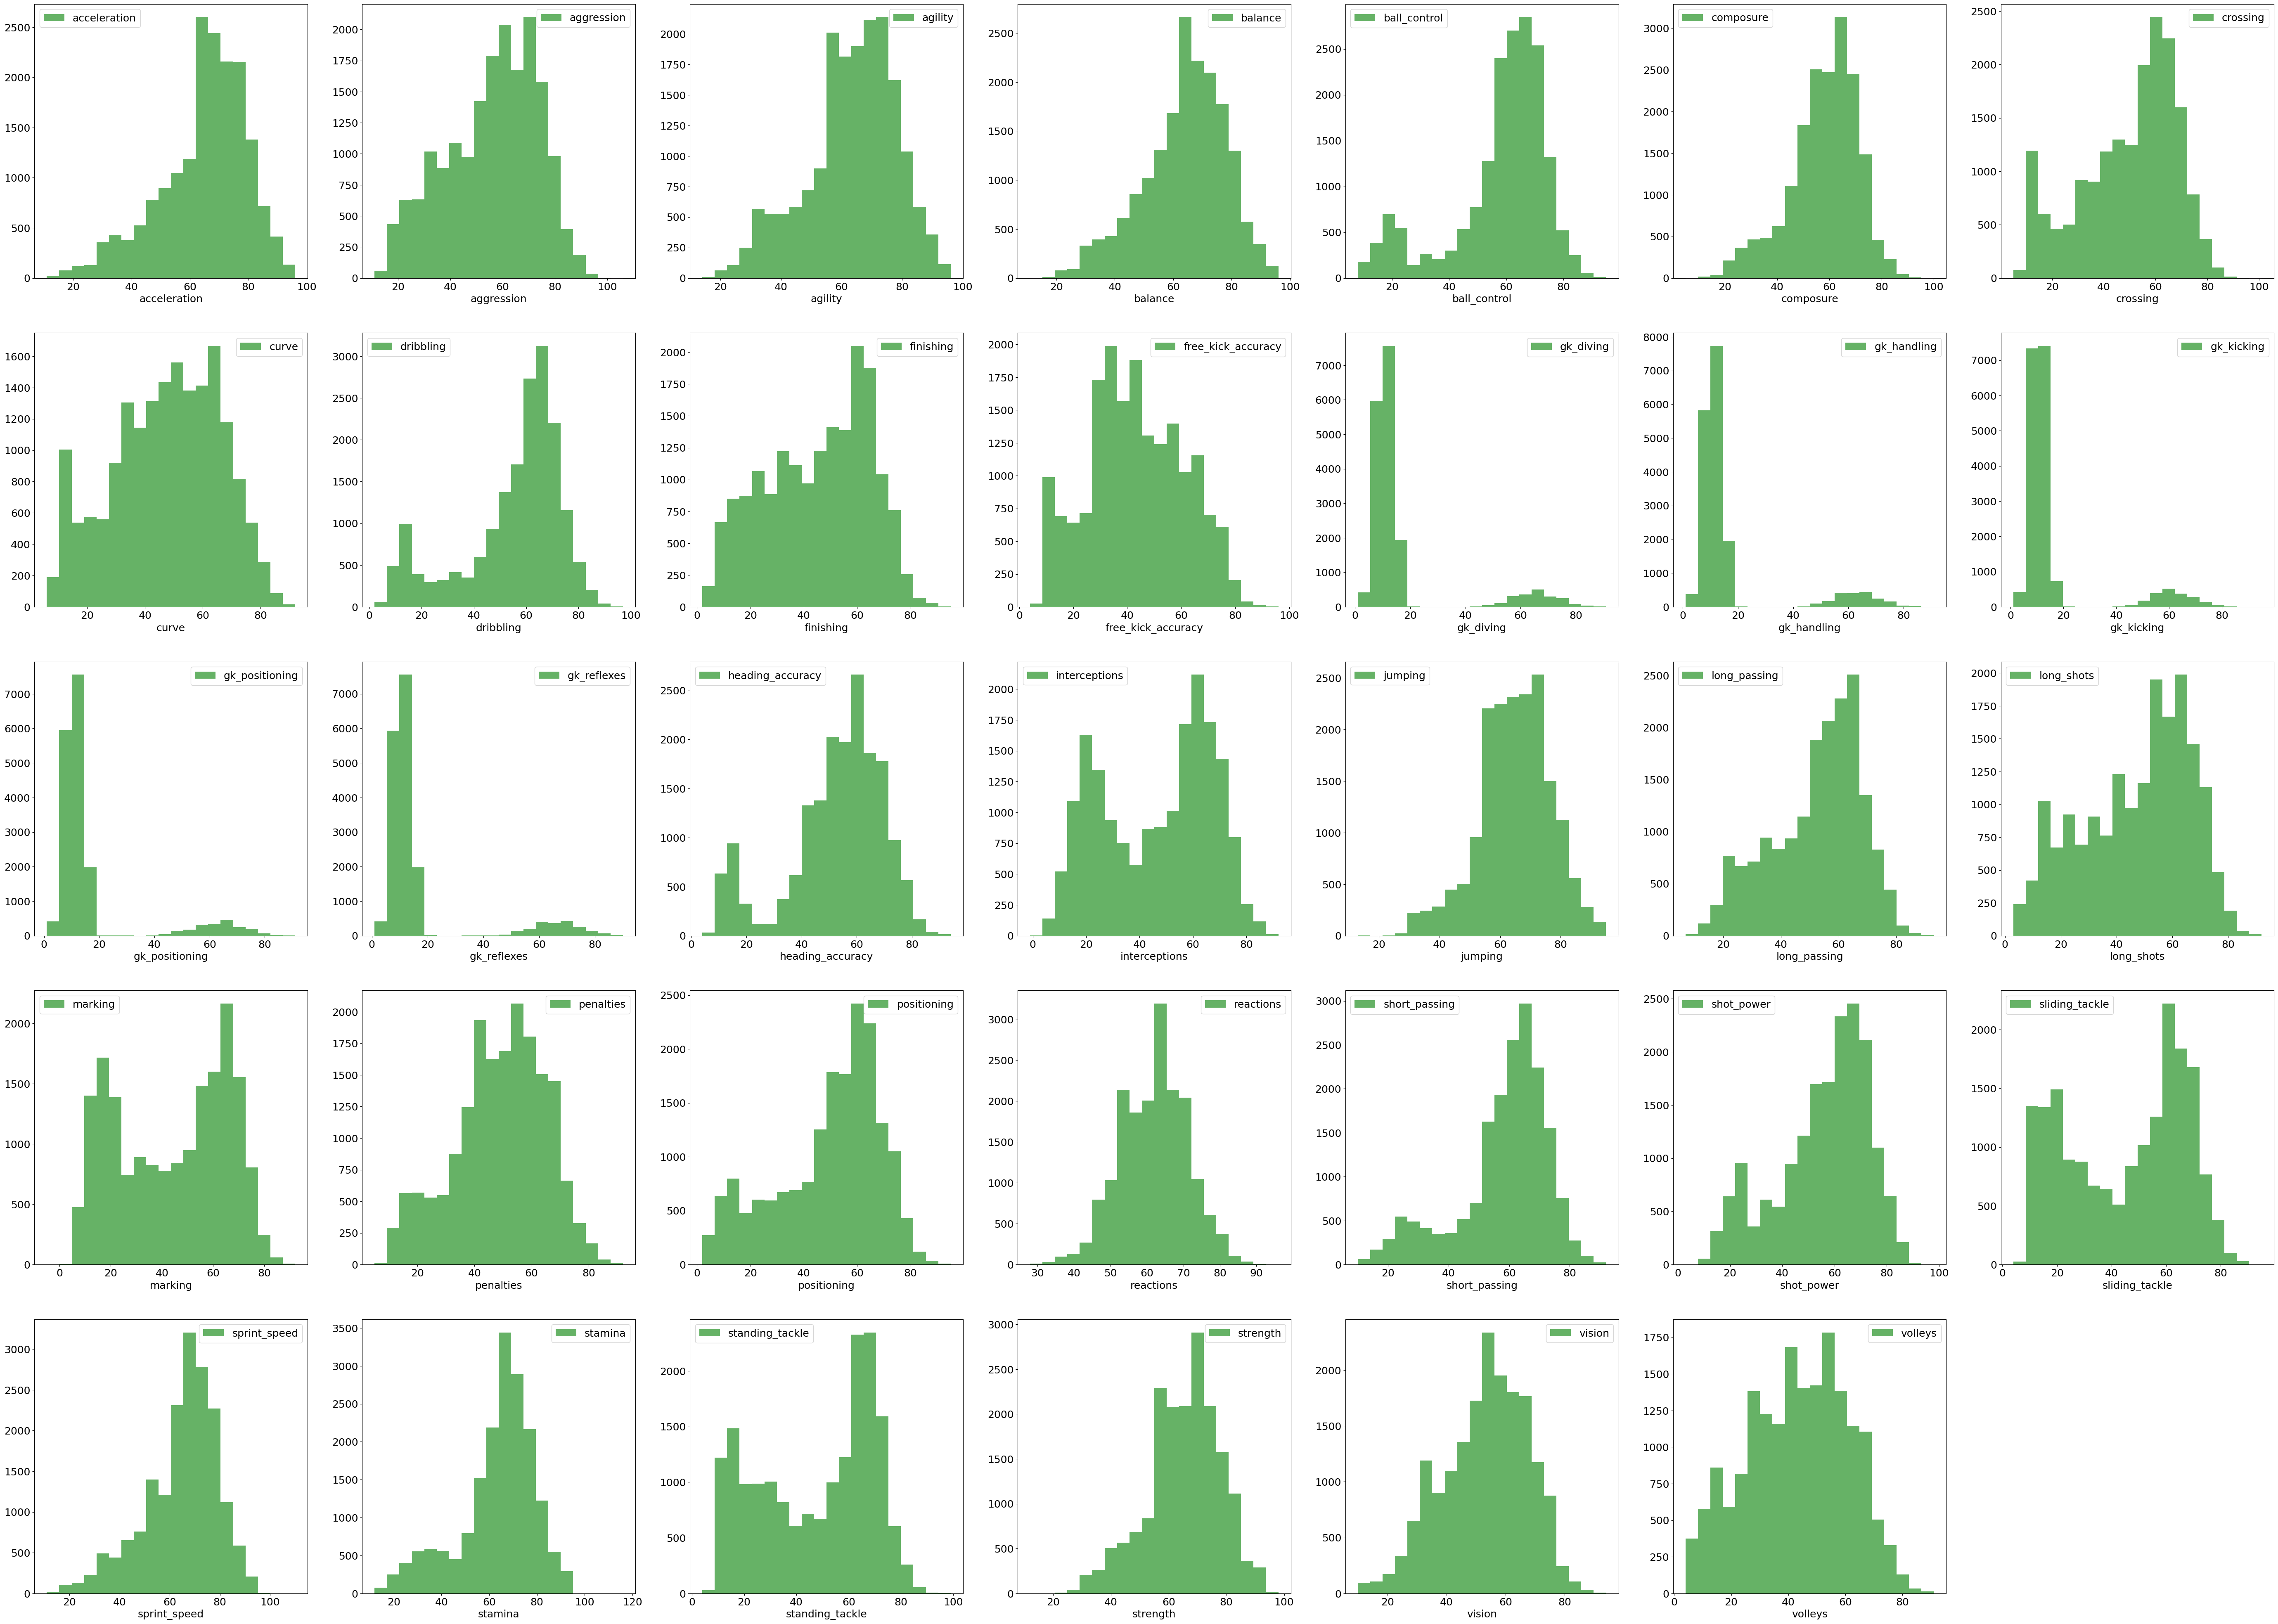

In [42]:
plot_distrib(data, ncols=7, nrows=5, figsize=(70, 50)) # calling the function we defined at the beginning of this notebook

### Boxplot

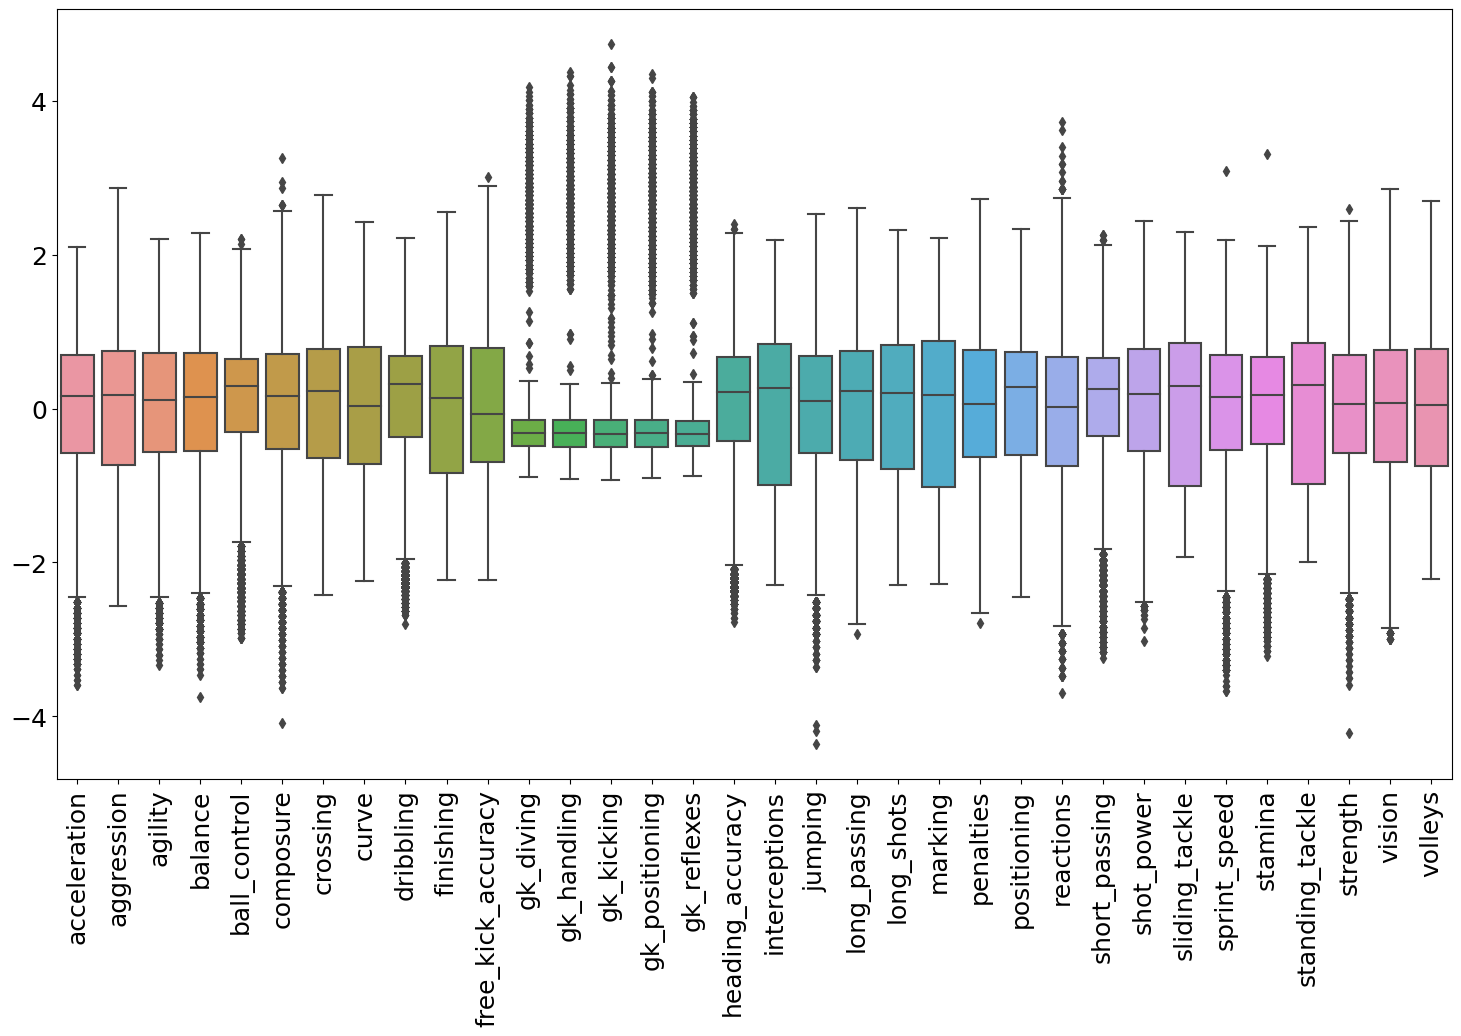

In [44]:
scaler = StandardScaler() # Scaling the data so the plot makes sense once it is ploted
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
ax = sns.boxplot(data=data_scaled)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.savefig('1.jpg', dpi=500, bbox_inches="tight")
plt.show()

<div style="background:#EEEDF5;"><div style="margin-left: .2cm">
    <b>Comments:</b>
</div></div>

<div style="margin-left: 0.4cm">
    <li>From the above visual methods, we can clearly identify obvious cluster consisting of Goalkeepers. But any further clustering seems difficult.</li>
</div>

## Clustering: K-Means

In [47]:
r_seed = 23  # random seed to use during modeling for reproducability purposes

In [ ]:
cluster_errors = []
for i in range(1, 15):
    n_clusters = i
    kmeans_pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "cluster",
                KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0),
            ),
        ]
    )
    kmeans_pipeline.fit(data)
    kmeans_pipeline.predict(data)
    cluster_errors.append(kmeans_pipeline.named_steps["cluster"].inertia_)

KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


<div style="background:#EEEDF5;border:0.1cm solid #00BAE5">
    <div style="margin: 0.2cm 0.2cm 0.2cm 0.2cm">
        <b style="color:#00BAE5">Note:</b>
        selection of the <b>optimal</b> number of clusters)
    </div>
</div>

### Finding the optimal number of clusters: Elbow Method

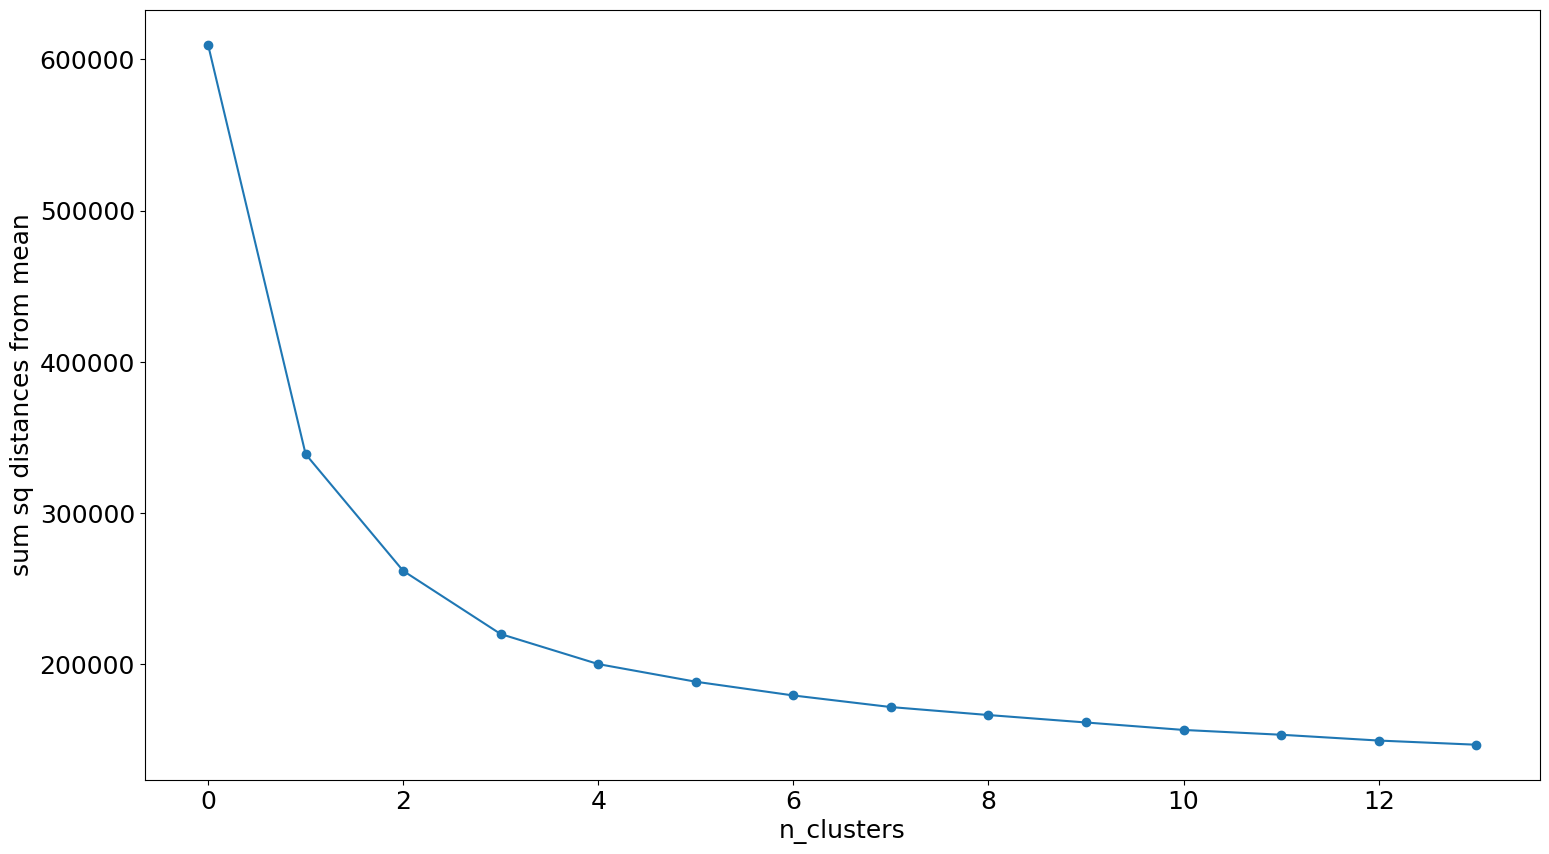

In [ ]:
# Quick and Dirty plot:

plt.clf()
plt.plot(cluster_errors, "o-")
plt.xlabel("n_clusters")
plt.ylabel("sum sq distances from mean")
plt.show()

<div style="background:#EEEDF5;"><div style="margin-left: .2cm">
    <b>Comments:</b>
</div></div>

<div style="margin-left: 0.4cm">
    <li>Visually, we could say that maybe 5 clusters is a good choice.</li>
</div>

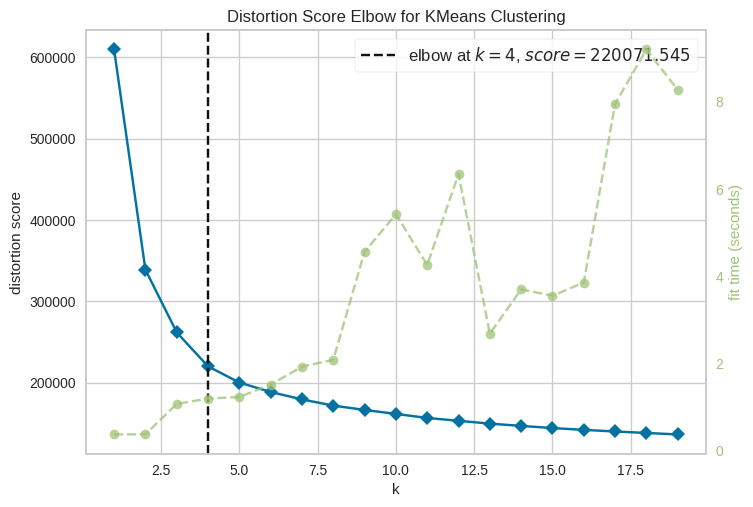

In [ ]:
# More fancy and viasually way to do the elbow method approach:

# Libraries and modules Installation:
# pip install yellowbrick

# Libraries:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

# List with Features:
features = list(data.columns)

# Setting up the content of variable 'X':
X = data.loc[:,features].values

numeric_transformer = Pipeline(steps=[('onehot', StandardScaler()),('imputer', SimpleImputer(strategy='mean'))])
numeric_features = list(range(len(features)))

feature_encoder = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

X = feature_encoder.fit_transform(X)

# Clustering model and visualizer:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))
visualizer.fit(X) # Fit the data to the visualizer
visualizer.poof(outpath="2.jpg") # Draw/show/poof the data


<div style="background:#EEEDF5;"><div style="margin-left: .2cm">
    <b>Comments:</b>
</div></div>

<div style="margin-left: 0.4cm">
    <li>With this extensive approach, it seems that 4 is a better number of clusters.</li>
</div>

### Finding the optimal number of clusters: Silhouette Method

<div style="background:#EEEDF5;border:0.1cm solid #00BAE5">
    <div style="margin: 0.2cm 0.2cm 0.2cm 0.2cm">
        <b style="color:#00BAE5">Note:</b>
        The code cell below was taken from sklearn documentation example of silhouette plotting: <a style="color:#00BAE5" href="https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html"> link</a>. By the way, a pipeline was included, which is cannot be found in the documentation link provided.
    </div>
</div>

TypeError: ignored

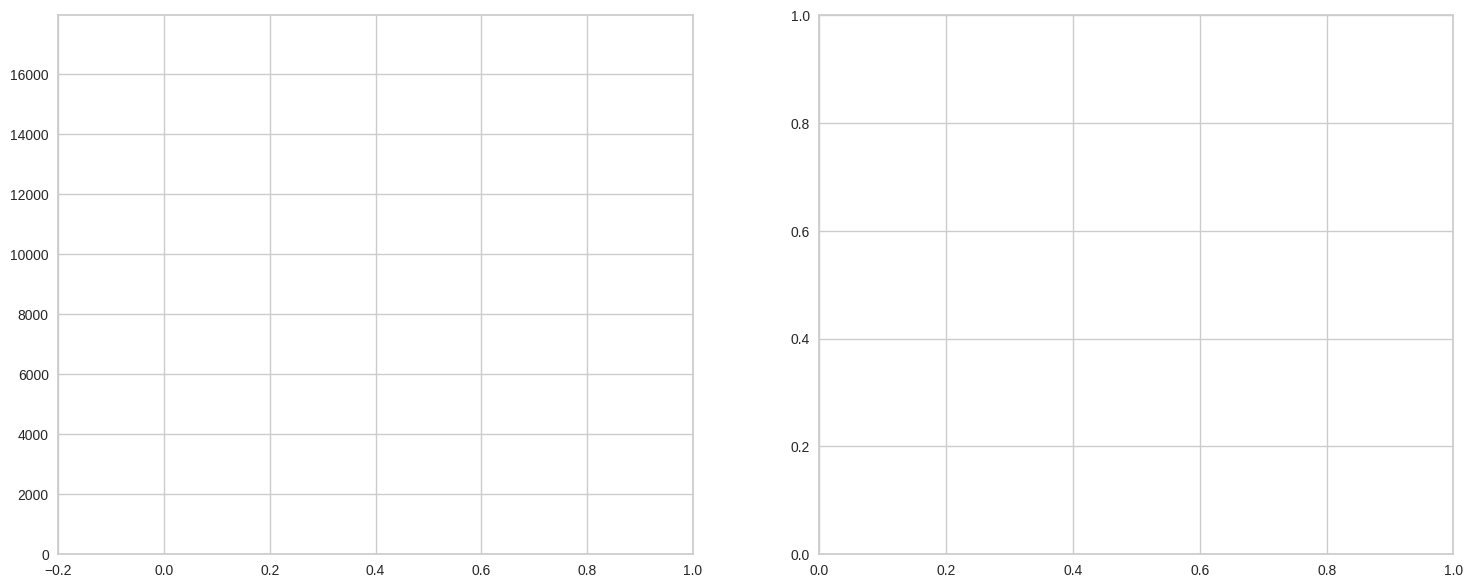

In [ ]:
range_n_clusters = range(2, 7)
X = data.copy()
X = X.values.astype("float32")
cols = data.columns

for n_clusters in range_n_clusters:

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.2, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the Pipeline with n_clusters value and a random generator seed for reproducibility.
    kmeans_pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "cluster",
                KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0, n_jobs=1),
            ),
        ]
    )
    cluster_labels = kmeans_pipeline.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i + 1) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels.astype(float) + 1) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k",
    )

    # Labeling the clusters
    pipeline_centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_
    centers = kmeans_pipeline.named_steps["scaler"].inverse_transform(pipeline_centers)
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature : " + cols[0])
    ax2.set_ylabel("Feature space for the 2nd feature :" + cols[1])

    plt.suptitle(
        (
            "Silhouette analysis for KMeans clustering on sample data "
            "with n_clusters = %d" % n_clusters
        ),
        fontsize=14,
        fontweight="bold",
    )
print("\n")
plt.savefig('3.jpg', dpi=2500, bbox_inches="tight")
plt.show()

<div style="background:#EEEDF5;"><div style="margin-left: .2cm">
    <b>Comments:</b>
</div></div>

<div style="margin-left: 0.4cm">
    <li>The <b>Silhouette Coefficient</b> is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). In other words, the higher the Silhouette score, the better the clusters are defined.</li>
    <li>By analysing both Elbow and Silhouette Methods we can see that best choice is 2 clusters as expected. But as we need something more we would go for the next best which will be <b>4 clusters.</b></li>
    <li>Try to make sense of the clusters formed using the current feature space.</li>
</div>

In [ ]:
n_clusters = 4
kmeans_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0)),
    ]
)
kmeans_pipeline.fit(data)
labels = kmeans_pipeline.predict(data)
centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_

cols = ["ball_control", "interceptions", "strength"]
# kmeans_pipeline.fit(data[cols])
data_kmeans = data[cols].copy()
data_kmeans["k-means4"] = labels
data_kmeans["k-means4clusters"] = data_kmeans["k-means4"].map(
    lambda i: "cluster " + str(i)
)

cols = ["ball_control", "interceptions", "strength", "k-means4clusters"]
g1 = sns.pairplot(data_kmeans, hue="k-means4clusters")
g1.fig.figsize = (18, 18)

### Finding the optimal number of clusters: Scatter plot with our 4 clusters selected

In [ ]:
data["k-means4"] = labels
plt.style.use("fivethirtyeight")
a = plt.scatter(data["composure"], data["interceptions"], c=data["k-means4"])
plt.savefig('4.jpg', dpi=500, bbox_inches="tight")
plt.show()

In [ ]:
data.iloc[:, 10:19].tail()

In [ ]:
attr.iloc[:, 10:20].tail()

In [ ]:
data["ID"] = attr["id"]
data.head()

In [ ]:

data["ID"].dtypes

### Clustering: Adding the playing possitions data to our clusters

In [ ]:
data_pos.head()

In [ ]:
print('\nAttributes df columns:\n', data.columns)
print('\nPositions df columns:\n', data_pos.columns)
print('\nAttributes df data types:\n', data.dtypes.unique())
print('\nPositions df data types:\n', data_pos.dtypes.unique())

In [ ]:
data_pos.dtypes.unique()

In [ ]:
data["ID"] = data["ID"].astype(str)
merged = pd.merge(data, data_pos, how="inner", on="ID")

In [ ]:
merged["Preferred Positions"].value_counts()

<div style="background:#EEEDF5;"><div style="margin-left: .2cm">
    <b>Comments:</b>
</div></div>

<div style="margin-left: 0.4cm">
    <li>We can see that most players have multiple preferred position. For simplicity, we will only keep the first position for each player.</li>
</div>

In [ ]:
merged["Preferred Positions"] = merged["Preferred Positions"].apply(
    lambda x: x.split(" ")[0]
)

In [ ]:
merged.head()

In [ ]:
merged["Preferred Positions"].value_counts()

### Clustering: Heatmap sorted based on kmeans cluster label

In [ ]:
plt.style.use("dark_background")
data_copy = data.copy()
data_copy["k-means4_hm"] = data_copy["k-means4"] * 25
sns.heatmap(data_copy.sort_values(by="k-means4").drop(columns=["k-means4", "ID"]))
plt.show();

<div style="background:#EEEDF5;"><div style="margin-left: .2cm">
    <b>Comments:</b>
</div></div>

<div style="margin-left: 0.4cm">
    <li>Use Player Preferred position to understand what type of players are in each cluster</li>
</div>

In [ ]:
c_tab = pd.crosstab(merged["k-means4"], merged["Preferred Positions"])
c_tab

--------------

<a style="color:#00BAE5" href='#P0'><div style="text-align:right;"> Back to Table of Contents </div></a>
<a id='P5'></a>
<h2 style="color:#EF475B">  Sankey Diagram</h2>

A Sankey diagram is a visualization tool used to depict a flow from one set of values to another. In our case, we want to show how our player's preferred position groups them into our clusters.

<div style="background:#EEEDF5;border:0.1cm solid #00BAE5">
    <div style="margin: 0.2cm 0.2cm 0.2cm 0.2cm">
        <b style="color:#00BAE5">Note:</b>
        Interactive Sankey diagram may not be able to render in jupyterLab try with Jupyter Notebook or add extensions for Lab.
    </div>
</div>

In [ ]:
merged.columns

In [ ]:
sankey_df = merged[["Preferred Positions", "k-means4", "acceleration"]].copy()
sankey_df.head()

In [ ]:
sankey_df = sankey_df.groupby(["Preferred Positions", "k-means4"]).count().reset_index()
sankey_df.head()

<div style="background:#EEEDF5;"><div style="margin-left: .2cm">
    <b>Comments:</b>
</div></div>

<div style="margin-left: 0.4cm">
    <li>Sankey uses index to plot so we would need to encode the Player Position</li>
</div>

In [ ]:
le = LabelEncoder()
sankey_df["Positions index"] = le.fit_transform(sankey_df["Preferred Positions"])

In [ ]:
list(le.classes_)

In [ ]:
sankey_df["k-means4_index"] = sankey_df["k-means4"] + len(le.classes_)

In [ ]:
sankey_df.head()

In [ ]:
label_sankey = list(le.classes_) + ["KMeans0", "KMeans1", "KMeans2", "KMeans3"]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=label_sankey,
            ),
            link=dict(
                source=list(sankey_df["Positions index"]),
                target=list(sankey_df["k-means4_index"]),
                value=list(sankey_df["acceleration"]),
            ),
        )
    ]
)

fig.update_layout(title_text="FIFA Cluster Analysis", font_size=15)
fig.write_image("5.jpg");

### 4 clusters seem to describe GK, Defenders, Mid-Fielders and Attackers:

- **0** --> Defenders [CB,RB,LB]
- **1** --> Goal Keepers [GK]
- **2** --> Mid-Fielders  [CDM,CM,LM,RM]
- **3** --> Attackers  [ST,CAM,LW,RW,CF]

The Goal Keepers cluster seems to be well defined. But there seems to be a bit of an overlap between the other 3 which may have occurred due to us selecting only the first preferred position of a player.

In [ ]:
import repoconfig as path

repo_path = path.paths["colab_path"]

In [ ]:
import configparser, os
config = configparser.ConfigParser()
config.read(os.path.join(os.path.dirname(__file__), 'repo_path.cfg'))

In [ ]:
! git status